In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from numba import jit
import numba

In [2]:
@jit(nopython=True)
def get_vec_mat2(x,y):
    mas=np.zeros((x,y,2,1),dtype=np.float32)
    for i in range(x):
        for j in range(y):
            mas[i,j,:,0]=[i,j]
    return mas        
    # return np.array([ [ [[i, j]] for i in range(int(x))] for j in range(int(y))], dtype=np.float32)

In [3]:
@jit(nopython=True)
def generate_gaus_params(x, y):
    theta = np.pi*np.random.random()
    a = np.random.random()/(x+y)*2.0*4
    b = np.random.random()/(x+y)*2.0*4

    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    M = np.array(((a, 0), (0, b)))
    # print(np.random.rand(1,2)*np.array([x, y])/3 + np.array([x, y])/6)
    return np.dot(np.dot(R, M), R.transpose()), np.random.rand(1,2)*np.array([x, y])/3 + np.array([x, y])/3

# @jit(nopython=True)
# def gaussian_func(M, mu, vec_mat):
#     x = vec_mat - mu
#     # x = np.transpose(x, (0, 1, 3, 2))
    
#     f = np.tensordot(M, x, axes=(0, 2))
#     f = np.transpose(f, (1, 2, 3, 0))
#     final = np.exp( -1* np.sum(x*f, axis=3))

    # return final

@jit(nopython=True)
def generate_multi_gaussian(x, y, n,vec_mat):
    # vec_mat = np.array([ [ [[i, j]] for i in range(int(x))] for j in range(int(y))], dtype=np.float32)
    mat = np.zeros((x, y), dtype=np.float32)
    for i in range(n):
        M, mu = generate_gaus_params(float(x),float(y))
        gauss_mat = gaussian_func2(M, mu, vec_mat) #.reshape(int(x), int(y))
        mat += gauss_mat*random.random()
    #plt.imshow(mat)
    return mat

In [4]:
@jit(nopython=True)
def gaussian_func2(M, mu, vec_mat):
    vec_mat=get_vec_mat2(100,100)
    # print(vec_mat.shape)
    x = vec_mat - mu.transpose()
    # print(x.shape)
    # print(M.shape)
    f=np.zeros((100,100,1))
    for i in range(100):
        for j in range(100):
            r=np.dot(M,x[i,j,:,:])
            r2=np.dot(x[i,j,:,:].transpose(),r)
            f[i,j,:]=r2
    # print(f.shape)
    return np.exp(f*-1)[:,:,0]

In [5]:
@jit(parallel = True)
def generate_multi_gaussian_alot(X,Y,n_images, n=15):
    vec_mat=get_vec_mat2(X,Y)
    pressure_mat=np.zeros((n_images,X,Y),dtype=np.float32)
    # hat_mat=round_fun((X, Y), (int(X/2), int(Y/2)), lambda x: hat(x,int(X/3)))
    for i in range(n_images):
        pressure_mat[i,:,:]=generate_multi_gaussian(X, Y, n,vec_mat) #*hat_mat
    return pressure_mat

In [6]:
def Convolution(input, filter, padding="SAME"):
  convolved = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding=padding)
  return convolved

def gauss_blur(input, num_angles, kern_size=40, fwhm=20):
    gauss_kernel = makeGaussian(size=kern_size, fwhm=fwhm)
    gauss_kernel = tf.tile(gauss_kernel, [1, 1, 1, num_angles])
    return Convolution(input, gauss_kernel, padding="SAME")

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    gauss = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    #plt.imshow(gauss)
    gauss = tf.constant(gauss, dtype=tf.float32)[:-1, :-1, tf.newaxis, tf.newaxis]
    return gauss

def rotate(input, theta):
    rot_layer = tf.keras.layers.RandomRotation(
      (theta, theta), fill_mode='constant', interpolation='bilinear',
      seed=None, fill_value=0.0)
    return rot_layer(input)

def derivate(input, num_angles):
    derivative_kernel = tf.constant(np.array([[1, -2, 1]]).transpose(), dtype=tf.float32)
    derivative_kernel = derivative_kernel[:, :, tf.newaxis, tf.newaxis]
    derivative_kernel = tf.tile(derivative_kernel, [1, 1, 1, num_angles])
    derivative_mat = Convolution(input, derivative_kernel, padding='VALID')
    return derivative_mat

def square(input):
    return tf.keras.layers.Activation(tf.math.square)(input)

def summ(input):
    return tf.math.reduce_sum(input, axis=1, keepdims=False)

def round_fun(shape,centr,fun):
  center=np.array(centr)
  mas=np.zeros(shape)
  for x in range(shape[0]):
    for y in range(shape[1]):
      p=np.array((x,y))
      mas[x,y]=fun(np.linalg.norm(p-center))
  return mas

def hat(x,r):
  if abs(x)<r:
    resalt=math.exp(1/8/((x/r)**2-1**2))
  else:
    resalt=0
  return resalt

In [7]:
def generate_dataset(n_images, n_angles, X = 91, Y = 91):
    hat_mat=round_fun((X, Y), (int(X/2), int(Y/2)), lambda x: hat(x,int(X/3)))
    # ars=tf.constant(np.ones(n_images)*10, dtype=tf.float32)
    # vec_mat = get_vec_mat(X,Y)
    # with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    #     pressure_mat = tf.map_fn(lambda n: generate_multi_gaussian2(X,Y,n,vec_mat),ars)

    # for i in range(n_images):
    #     pressure_mat.append(generate_multi_gaussian(X, Y, 10)*hat_mat)
    # print ("Gauss_generated")
    pressure_mat = generate_multi_gaussian_alot(X,Y,n_images)
    pressure_mat = tf.constant(pressure_mat*hat_mat, dtype=tf.float32)
    print (pressure_mat.shape)
    pressure_mat = pressure_mat[:, :, :, tf.newaxis]
    print (pressure_mat.shape)
    pressure_mat2=tf.tile(pressure_mat,[10,1,1,1])
    pressure_mat_angl=tf.keras.layers.RandomRotation(
      (0, 2*np.pi), fill_mode='constant', interpolation='bilinear',
      seed=None, fill_value=0.0)(pressure_mat2)
    pressure_tensor = pressure_mat_angl[:,:,:,0]
    rotated_array = []
    for i in range (n_angles):
      rot_mat = rotate(pressure_mat_angl, i*np.pi/n_angles)
      rotated_array.append(rot_mat)

    rot_tensor = tf.concat(rotated_array, axis=-1)
    print (rot_tensor.shape)

    
    pressure_tensor = tf.slice(pressure_tensor, [0, int(X/6.0), int(Y/6.0)], [n_images*10, int(X*(1.0 - 2.0/6.0)), int(Y*(1.0 - 2.0/6.0))])
    sliced_tensor = tf.slice(rot_tensor, [0, int(X/6.0), int(Y/6.0), 0], [n_images*10, int(X*(1.0 - 2.0/6.0)), int(Y*(1.0 - 2.0/6.0)), n_angles])
    
    blured_mat = gauss_blur(sliced_tensor, n_angles, kern_size=50, fwhm=20)
    print (blured_mat.shape)

    print (blured_mat.shape)

    sq_deriv_tensor =  square(derivate(blured_mat,n_angles))

    sum_tensor = summ(sq_deriv_tensor)

    print(sum_tensor.shape)

    return sum_tensor, pressure_tensor, sliced_tensor, sq_deriv_tensor

In [8]:
def ferst_dataset(n_images, X = 97, Y = 97):
    hat_mat=round_fun((X, Y), (int(X/2), int(Y/2)), lambda x: hat(x,int(X/3)))
    pressure_mat = generate_multi_gaussian_alot(X,Y,n_images)
    pressure_mat_a = pressure_mat*hat_mat
    # with open('fresh_gauss15.npy', 'rb') as f:
    #     pressure_mat_old = np.load(f)
    # pressure_mat_new = np.concatenate([pressure_mat_old, pressure_mat_a], axis=0)
    with open('fresh_gauss15_100000.npy', 'wb') as f:
        np.save(f, pressure_mat_a)

In [9]:
ferst_dataset(100000)

/tmp/ipykernel_5191/2868327652.py:7: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  pressure_mat[i,:,:]=generate_multi_gaussian(X, Y, n,vec_mat) #*hat_mat
/tmp/ipykernel_5191/2868327652.py:7: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  pressure_mat[i,:,:]=generate_multi_gaussian(X, Y, n,vec_mat) #*hat_mat
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [53]:
with open('fresh_gauss.npy', 'rb') as f:
      pressure_mat = np.load(f)

In [54]:
pressure_mat.shape

(10000, 97, 97)

In [ ]:
# inputt, output, sliced_tensor, sq_deriv_tensor = generate_dataset(10, 4, X = 97, Y = 97)

In [37]:
with open('gausses.npy', 'wb') as f:
    np.save(f, inputt.numpy())
    np.save(f, output.numpy())
    np.save(f, sliced_tensor.numpy())
    np.save(f, sq_deriv_tensor.numpy())

In [41]:
del output, sliced_tensor, sq_deriv_tensor

In [105]:
output.numpy().shape

(10000, 61, 61)

In [24]:
input2=[inputt[:,::2,i] for i in range(4)]
output2=output[:,::2,::2]

In [26]:
print(output2.shape)
print(input2[0].shape)

(100, 32, 32)
(100, 32)


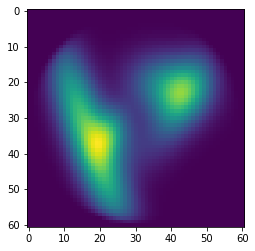

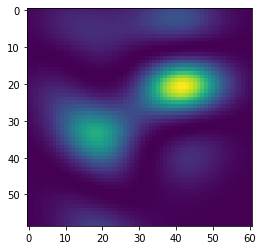

In [26]:
plt.imshow(output[49])
plt.show()
plt.imshow(sq_deriv_tensor[49,:,:,0])
plt.show()

In [ ]:
def get_siamese_model(input_shape,n_angl):
    """
        Model architecture
    """
    inputs=[layers.Input(input_shape) for _ in range(n_angl)]
    # inputs=tf.tile(layers.Input(input_shape)[tf.newaxis,:,:,:],[n_angl,1,1,1,])
    # Define the tensors for the two input images
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(layers.Conv1D(4, 5, activation='relu', input_shape=input_shape)) # kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)
    model.add(layers.MaxPooling1D())
    model.add(layers.Conv1D(8, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D())
    # model.add(layers.Conv1D(16, 3, activation='relu', input_shape=input_shape))
    # model.add(layers.MaxPooling1D())
    # model.add(layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
    # model.add(layers.MaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(8, activation='relu'))
    
    # Generate the encodings (feature vectors) for the two images
    encodeds = tf.stack([model(input) for input in inputs], axis=1)
    # encodeds = tf.map_fn(model, inputs)
    # encodeds = tf.transpose(encodeds, perm=[1,0,2,3])
    flat_layer = layers.Flatten()(encodeds)
    dense_layer = layers.Dense(32, activation='relu')(flat_layer)
    flat_resalt = layers.Dense(16*16, activation='relu')(dense_layer)
    resalt = layers.Reshape((16, 16))(flat_resalt)
    # print(tf.stack(inputs,axis=3))
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=inputs,outputs=resalt)
    
    # return the model
    return siamese_net

In [ ]:
model = get_siamese_model((16,1),4)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

In [ ]:
model.fit(input2, output2, epochs = 100, validation_split=0.1, verbose=1)

In [ ]:
predictions = model.predict(input2)

In [ ]:
N = 901
plt.imshow(predictions[N])
plt.show()
plt.imshow(output.numpy()[N])